In [1]:
import random
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import akshare as ak

deque 是一种容器数据类型，可以在两端高效地添加和删除元素。
与列表相比，deque 在两端的操作时间复杂度为 𝑂(1)，而列表在一端的操作时间复杂度为 𝑂(𝑛)

In [2]:
torch.cuda.is_available()

True

In [3]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity, seed):  # capacity: 表示回放池的最大容量
        random.seed(int(seed))
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)
    
class Qnet(nn.Module):
    ''' 多层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dims, action_dim):
        super(Qnet, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(state_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            self.layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.layers.append(nn.Linear(hidden_dims[-1], action_dim))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)  # 输出层
        return x

In [4]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dims,  action_dim, learning_rate, gamma,
                 epsilon, target_update, device, seed):
        np.random.seed(seed)
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dims, self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dims, self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        x = self.epsilon / (self.count + 1)
        decay_epsilon = x if x > 0.05 else 0.05
        if np.random.random() < decay_epsilon:
            action_idx = np.random.randint(self.action_dim)
        else:
            state = state.clone().detach().float().to(self.device)
            # state = torch.tensor(state, dtype=torch.float).to(self.device)
            action_idx = self.q_net(state.reshape(1,-1)).argmax().item()
        return action_idx

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        states = states.clone().detach()
        actions = actions.clone().detach()
        rewards = rewards.clone().detach()
        next_states = next_states.clone().detach()
        dones = dones.clone().detach()

        q_values = self.q_net(states).gather(dim=1, index=actions)  # Q值

        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(dim=1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [5]:
class MarketEnv:
    def __init__(self, state_space, action_space, lookback, tc, seed):
        np.random.seed(seed)
        self.states = state_space
        self.actions = action_space
        self.lookback = lookback
        self.position = 0
        self.reward = 0
        self.tc = tc
        
    def step(self, state_idx, action_idx):
        state = self.states[state_idx]
        action = self.actions[action_idx]
        done = False

        # 下一个状态的索引
        if state_idx < len(self.states) - 1 - self.lookback:
            next_state = self.states[state_idx + self.lookback]
            self.position += action
            reward = self.get_reward(state, action)
        else:
            next_state = self.states[len(self.states) - 1]
            reward = 0
            done = True
        
        return next_state, reward, done
    
    def get_reward(self, state, action):
        # 从[0,1,2]映射到[-1,0,1]
        action -= 1
        
        # t, t+h日收盘价
        close_h = state.squeeze()[-3].item()
        close_t = state.squeeze()[3].item()

        # 计算涨跌幅
        ret_ratio = close_h / close_t

        if self.position == 0:
            if action > 0:  # 做多
                self.reward = (1 - self.tc) * ret_ratio - 1
                self.position = 1
            elif action == 0:
                self.reward = 1 - ret_ratio
                self.position = 0
            else:
                self.reward = 1 - (1 - self.tc) * ret_ratio
                self.position = -1

        elif self.position > 0:
            if action < 0:  # 平仓
                self.reward = (1 - self.tc) * (2 - ret_ratio) - 1
                self.position = 0
            else:
                self.reward = ret_ratio - 1
                self.position = 1

        elif self.position < 0:
            if action > 0:  # 平仓
                self.reward = (1 - self.tc) * (ret_ratio - 2) - 1
                self.position = 0
            else:
                self.reward = ret_ratio - 1
                self.position = -1
                 
        return self.reward * 100
    
    def reset(self):
        self.position = 0
        self.reward = 0
        state_idx = np.random.randint(0, len(self.states))
        state = self.states[state_idx]
        return state, state_idx
    
# 投票决策
def vote_action(state):
    actions = [agent.take_action(state) for agent in agent_list]
    # 统计每个动作的频次
    action_counts = np.bincount(actions)
    # 选择频次最高的动作
    final_action = np.argmax(action_counts)
    return final_action

In [6]:
# 获取行情数据
data = ak.index_zh_a_hist(symbol="000001", start_date="20070104", end_date="20220630").set_index("日期")
cols = ["开盘", "最高", "最低", "收盘"]
data = data[cols]

# 计算z-score
lookback = 5
window = 252
data["past_252_mean"] = data["收盘"].rolling(window=window).mean()
data["past_252_std"] = data["收盘"].rolling(window=window).std()
data.dropna(inplace=True)
data[cols] = data[cols].subtract(data["past_252_mean"], axis=0).div(data["past_252_std"], axis=0)
data = data[cols]
train_data = data["2007":"2017"]
test_data = data["2017":"20220630"]
train_start_date, train_end_date = train_data.index[0], train_data.index[-1]
test_start_date, test_end_date = test_data.index[0], test_data.index[-1]

# 存储状态列表(训练)
states = []
for i in range(lookback - 1, len(train_data)):
    one_state = data.iloc[i - lookback + 1: i, :]
    one_state = one_state.to_numpy().flatten()
    states.append(torch.tensor(one_state))

actions = [0, 1, 2]  # 0: sell，1: hold, 2: buy

lr = 2e-3
gamma = 0.7
num_episodes = 30
state_dim = states[0].numel()
hidden_dims = [128, 256]
action_dim = 3
tc = 5e-4   # 单边费率万分之五
epsilon = 0.9
target_update = 5  # 每训练n个回合，更新一次目标网络
buffer_size = 64
minimal_size = 32
batch_size = 32
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")

# 设置多个随机种子
num_seeds = 100
seeds = np.random.randint(0, 10000, size=num_seeds)

# 初始化
env_list = [MarketEnv(states, actions, lookback, tc, seed) for seed in seeds]
replay_buffer_list = [ReplayBuffer(buffer_size, seed) for seed in seeds]
agent_list = [DQN(state_dim, hidden_dims, action_dim, lr, gamma, epsilon, target_update, device, seed) for seed in seeds]

# 训练模型

for i in range(num_seeds):
    env = env_list[i]
    replay_buffer = replay_buffer_list[i]
    agent = agent_list[i]
    return_list = []
    with tqdm(total=int(num_episodes), desc=f"Seed {i + 1}") as pbar:
        for i_episode in range(int(num_episodes)):
            episode_return = 0
            state, state_idx = env.reset()
            done = False

            while not done:
                action_idx = agent.take_action(state)
                action = actions[action_idx]
                next_state, reward, done = env.step(state_idx=state_idx, action_idx=action_idx)
                # print(reward)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                state_idx += lookback
                episode_return += reward
                
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    "episode": f"{num_episodes * i + i_episode + 1}",
                    "return": f"{np.mean(return_list):.3f}"
                })
                
            pbar.update(1)

Seed 20:  23%|██▎       | 7/30 [00:04<00:15,  1.44it/s]


KeyboardInterrupt: 

In [116]:
# 存储状态列表(训练)
test_states = []
for i in range(lookback - 1, len(test_data)):
    one_state = data.iloc[i - lookback + 1: i, :]
    one_state = one_state.to_numpy().flatten()
    test_states.append(torch.tensor(one_state))

action_list = []
for state in tqdm(test_states, desc="state"):
    action_list.append(vote_action(state))  # 使用投票结果

state: 100%|██████████| 1325/1325 [00:01<00:00, 874.03it/s]


In [94]:
# action_list = []
# for _ in range(len(test_states)):
#     action_list.append(2)

In [117]:
ret = ak.index_zh_a_hist(symbol="000300", start_date=test_start_date, end_date=test_end_date).set_index("日期")
# ret = ak.index_zh_a_hist(symbol="000001", start_date="2017", end_date="20220630").set_index("日期")
ret = ret[lookback - 1:]
ret["动作"] = [x-1 for x in action_list]   # [0,1,2] --> [-1,0,1]
ret["动作"] = ret["动作"].shift(lookback)
ret.dropna(inplace=True)
date_list = ret.index.tolist()

position = 0
position_list = []
return_list = [0, ]
for i in range(len(ret) - 1):
    date = date_list[i]
    next_date = date_list[i + 1]
    action = ret.loc[date, "动作"]
    next_chg = ret.loc[next_date, "涨跌幅"] * 0.01  # 次日涨跌幅
    close_open_spread = ret.loc[next_date, "开盘"] / ret.loc[date, "收盘"] - 1  # 次日开盘涨跌幅
    if position == 0:
        if action <= 0:
            return_list.append(0)    # 保持空仓
            position = 0
        else:
            return_list.append(next_chg)    # 开仓做多
            position = 1
    else:
        if action >= 0:
            return_list.append(next_chg)    # 继续持有
            position = 1
        else:
            return_list.append(close_open_spread)  # 次日开盘卖出
            position = 0
    
    position_list.append(position)

return_array = np.array(return_list)
cum_return = (1 + return_array).cumprod()

In [118]:
np.mean(position_list)

0.4269406392694064

全部满仓：0.68

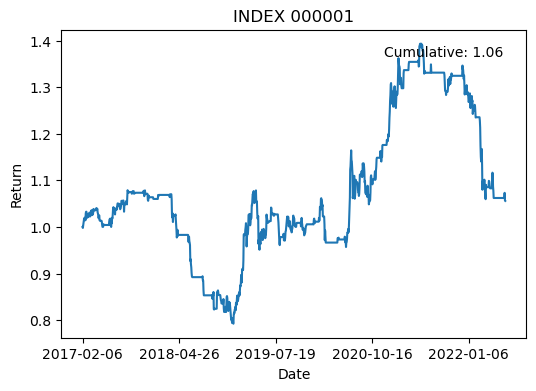

In [119]:
import matplotlib.ticker as ticker
def plot(x, y, xlabel="x", ylabel="y", title="Cumulative Return", dpi=100):
    _, ax = plt.subplots(figsize=(6,4), dpi=dpi)
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.text(
        0.95, 0.95, f'Cumulative: {y[-1]:.2f}',
        horizontalalignment='right',
        verticalalignment='top',
        transform=plt.gca().transAxes
    )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(300))
    plt.show()
    

plot(ret.index.tolist(), cum_return, "Date", "Return", "INDEX 000001")